<p><font size=7 color="#2E1698"><u><center>Twitter French Analysis</center></u></font></p><br>
<p><font size=3.2 color="#2E1698"><i><u>Introduction:</u></i> explain our data blablabla we are here aiming to manipulate the data that we generated before.</font><p>
<br>
<font color="#206B50" size = 4.5><center>**SUMMARY**</center></font>
<font size=3.2 color="#2E1698">
<b>Part I:</b> 
      <ol>
          <li>Data visualization</li>
          <li>Data cleaning</li>
      </ol>
<br>
<b>Part II:</b>
      <ol>
          <li>Provide a list of the 15 most common words</li>
          <li>Provide a list of the 2 pairs of words having the highest co-occurrence frequency</li>
      </ol>
<br>
<b>Part III:</b>
      <ol>
          <li>Build a graphical representation of the most frequent words with their polarity (pos/neg or anger/joy/fear/...)</li>
          <li>Indicate the 3 most frequent representatives words in each category</li>
          <li>Compare the results of the two approaches</li>
      </ol>
</font>
<br>
<br>

<p><font size=4.5 color="#206B50"><center><B>PART I - 1. DATA VISUALIZATION</B></center></font></p>
<font size=3 color="#2E1698">First things first, let's import the csv file. We are using french tweets this is why we need to specify the UTF-8 encoding. To have a better idea of our database we decided to show the first 5 lines.</font><br>

In [1]:
# Please uncomment the following lines to download the packages that are necessary for this notebook.

#install.packages("tm") #need R 3.3.2
#install.packages("wordcloud")
#install.packages("SnowballC")
#install.packages("plyr")
#install.packages("devtools")
#require("devtools")
#install_github("lchiffon/wordcloud2")

In [2]:
yourPath = paste0(getwd(),"/data/debat_primaire_20000.csv")
tweets = read.csv(yourPath, encoding="UTF-8")
print(dim(tweets))
head(tweets, n = 5)

[1] 20000    17


X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
1,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,FALSE,0,NA,2017-01-19 22:50:06,FALSE,NA,8.222146e+17,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",OuAtas,0,FALSE,FALSE,NA,NA
2,C'est bon @GoogleFR @TwitterFrance avez vous bien collectés mes données ? Bonne nuit #numerique #bigdata #PrimaireLeDébat,FALSE,0,NA,2017-01-19 22:50:06,FALSE,NA,8.222146e+17,NA,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",WajdiHA2,0,FALSE,FALSE,NA,NA
3,"RT @DeLuca_Patrice: .@manuelvalls ""Je veux incarner l'espérance, venez voter dimanche!"" #AvecValls #PrimaireLeDebat",FALSE,0,NA,2017-01-19 22:50:06,FALSE,NA,8.222146e+17,NA,"<a href=""http://www.twitter.com"" rel=""nofollow"">Twitter for Windows</a>",ProvenceValls,5,TRUE,FALSE,NA,NA
4,"RT @DeLuca_Patrice: .@manuelvalls ""Nous avons besoin d'une Europe forte et unie"" #AvecValls #PrimaireLeDebat #Valls2017",FALSE,0,NA,2017-01-19 22:50:05,FALSE,NA,8.222146e+17,NA,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Jojo29_BZH,10,TRUE,FALSE,NA,NA
5,RT @LPF_Paris18: #PrimaireLeDebat Dis donc @manuelvalls c'est à coup de #decheancedenationalite et de #49Al3 que tu penses nous sauver? #Mo…,FALSE,0,NA,2017-01-19 22:50:05,FALSE,NA,8.222146e+17,NA,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",FranceCredible,6,TRUE,FALSE,NA,NA


<p><font color="#2E1698" size = 3.2>As you can see, our data frame contains <font color="red">17</font> columns and <font color="red">20 000</font> rows, let's see the 10 firsts rows.</font><br></p>
<font color="#2E1698" size = 3.2>Let's see if all the columns have multiple values, or if some are useless.</font>

In [3]:
cat("UNIQUE", "\n")
cat("Favorited: ",head(unique(tweets$favorited)), "\n")
cat("FavoriteCount: ",head(unique(tweets$favoriteCount)), "\n")
cat("ReplyToSN: ",head(unique(tweets$replyToSN)), "\n")
cat("ReplyToUID: ",head(unique(tweets$replyToUID)), "\n")
cat("Id: ",head(unique(tweets$id)), "\n")
cat("IsRetweet: ",head(unique(tweets$isRetweet)), "\n")
cat("Lattitude: ",head(unique(tweets$latitude)), "\n")
cat("Longitude: ",head(unique(tweets$longitude)), "\n\n")

UNIQUE 
Favorited:  FALSE 
FavoriteCount:  0 1 3 2 20 17 
ReplyToSN:  NA 216 36 8 159 32 
ReplyToUID:  NA 8.144061e+17 500852226 87425370 465866698 14389177 
Id:  8.222146e+17 8.222146e+17 8.222146e+17 8.222146e+17 8.222146e+17 8.222146e+17 
IsRetweet:  FALSE TRUE 
Lattitude:  NA 46.813 48.88828 48.88826 48.88828 48.89228 
Longitude:  NA 8.4445 2.395666 2.395496 2.39554 2.331879 



In [4]:
cat("Favorited TRUE: ", length(which(tweets$favorited == "TRUE")), "\n")
cat("Favorited FALSE: ", length(which(tweets$favorited == "FALSE")), "\n\n")

Favorited TRUE:  0 
Favorited FALSE:  20000 



<font  
color="#2E1698" size = 3.2>We can see here that there is no TRUE value for favorited, only FALSE. favorited is useless though.</font>

In [5]:
cat("No favoritedCount: ", length(which(tweets$favoriteCount == 0)), "\n")
cat("At least one favoritedCount: ", length(which(tweets$favoriteCount != 0)), "\n")
cat("Percentage of tweets that have favoritedCount",(3919/20000)*100,"%")

No favoritedCount:  16081 
At least one favoritedCount:  3919 
Percentage of tweets that have favoritedCount 19.595 %

<font color="#2E1698" size = 3.2>The favoriteCount have multiple values, 20% of the are not 0 we better keep this column. It is maybe a significative data</font>

In [6]:
cat("Tweets containing longitude information: ", length(which(tweets$longitude != "NA")), "\n")
cat("Tweets containing latitude information: ", length(which(tweets$latitude != "NA")), "\n")
cat("Percentage of tweets containing infos: ", 9/20000*100, "%")

Tweets containing longitude information:  9 
Tweets containing latitude information:  9 
Percentage of tweets containing infos:  0.045 %

<font color="#2E1698" size = 3.2>There is only 9 tweets over 20 000 that contains latitude and longitude, this represents only 0.045% of the tweets, this info can be considered as useless, and we can delete this two columns too.</font>


In [7]:
cat("Tweets with replyToSN not null", length(which(tweets$replyToSN != "NA")),"\n")
cat("Tweets with replyToUID not null", length(which(tweets$replyToUID != 'NA')), "\n")
cat ("Tweets with replyToSID not null", length(which(tweets$replyToSID != 'NA')), "\n")
cat("Percentage of tweets containing replyToSN/UID", 698/20000*100, "%", "\n")
cat("Percentage of tweets containing replyToSID", 445/20000*100, "%")

Tweets with replyToSN not null 698 
Tweets with replyToUID not null 698 
Tweets with replyToSID not null 445 
Percentage of tweets containing replyToSN/UID 3.49 % 
Percentage of tweets containing replyToSID 2.225 %

<font color="#2E1698" size = 3.2>There is only about 3.5% of the replytoSN and replyToUID data that are not NA, we can delete these two columns as they don't seem to be interesting to study. Same thing for the replyToSID, with less than 2.5%.</font> <br><br><br>
<font size=4.5 color="#206B50"><center><B>PART I - 2. DATA CLEANING</B></center></font>
<br>
<font color="#2E1698" size = 3.2>Let's delete these useless columns!</font>

In [8]:
tweets <- subset(tweets, select=-c(replyToSN,replyToUID, replyToSID, latitude, longitude, favorited))
head(tweets)

X,text,favoriteCount,created,truncated,id,statusSource,screenName,retweetCount,isRetweet,retweeted
1,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",OuAtas,0,FALSE,FALSE
2,C'est bon @GoogleFR @TwitterFrance avez vous bien collectés mes données ? Bonne nuit #numerique #bigdata #PrimaireLeDébat,0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",WajdiHA2,0,FALSE,FALSE
3,"RT @DeLuca_Patrice: .@manuelvalls ""Je veux incarner l'espérance, venez voter dimanche!"" #AvecValls #PrimaireLeDebat",0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://www.twitter.com"" rel=""nofollow"">Twitter for Windows</a>",ProvenceValls,5,TRUE,FALSE
4,"RT @DeLuca_Patrice: .@manuelvalls ""Nous avons besoin d'une Europe forte et unie"" #AvecValls #PrimaireLeDebat #Valls2017",0,2017-01-19 22:50:05,FALSE,8.222146e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Jojo29_BZH,10,TRUE,FALSE
5,RT @LPF_Paris18: #PrimaireLeDebat Dis donc @manuelvalls c'est à coup de #decheancedenationalite et de #49Al3 que tu penses nous sauver? #Mo…,0,2017-01-19 22:50:05,FALSE,8.222146e+17,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",FranceCredible,6,TRUE,FALSE
6,"""J'ai un progrès précis, crédible, de gauche"", a dit @Vincent_Peillon dans sa conclusion https://t.co/Zs9UHNLcNb… https://t.co/mBtiNvJIAb",0,2017-01-19 22:50:05,TRUE,8.222146e+17,"<a href=""http://snappytv.com"" rel=""nofollow"">SnappyTV.com</a>",Europe1,0,FALSE,FALSE


<font color="#2E1698" size = 3.2>If we want to use the text, it have to be cleaned first</font>


In [9]:
clean_text = function(x)
{
    #To convert the text in lowercase
    try.error = function(z)
    {
        y = NA
        try_error = tryCatch(tolower(z), error=function(e) e)
            if (!inherits(try_error, "error"))
                y = tolower(z)
                return(y)
    }
            
    x = sapply(x, try.error)
    
    #Keep lepen > 3 letters
    x = gsub("le pen", "lepen", x)
    x = gsub("#primaire\\w+ *", "", x)
            
    #remove all links starting by http
    x = gsub('http\\S+\\s*', '', x)
    
    # modifying ne and n' to keep negation in cleaned tweet.
    x = gsub('ne', 'nenene', x)
    x = gsub("n'", 'nenene ', x)
    
    # replace apostrophes
    x = gsub("'", " ", x)

    # remove punctuation except @, #, _, -
    x = gsub("@", "AAAAAAAAAAA", x)
    x = gsub("#", "BBBBBBBBBBB", x)
    x = gsub("_", "CCCCCCCCCCC", x)
    x = gsub("-", "DDDDDDDDDDD", x)
    x = gsub("[[:punct:]]", " ", x)
    x = gsub("AAAAAAAAAAA", "@", x)
    x = gsub("BBBBBBBBBBB", "#", x)
    x = gsub("CCCCCCCCCCC", "_", x)
    x = gsub("DDDDDDDDDDD", "-", x)
            
    # correcting the spaces after the conserved @
    x = gsub("@ ", "@", x)
            
    # correcting the spaces after the conserved _
    x = gsub("_ ", "_", x)
            
    # correcting the spaces after the conserved -
    x = gsub("- ", "-", x)
    
    # remove numbers/Digits
    x = gsub("[[:digit:]]", "", x)
    
    # remove tabs
    x = gsub("[ |\t]{2,}", " ", x)
            
    # remove blank spaces at the beginning/end
    x = gsub("^ ", "", x)  
    x = gsub(" $", "", x)
    
    
    # As we have already a column indicating if the tweet is a retweet or not 
    # we can remove "RT @xxx" in the tweet header
    x = gsub("rt @\\w+ *", "", x)
    
    # Remove words of 3 letters or less excepted negation, bon and loi:
    x = gsub ('pas', 'paspaspas', x)
    x = gsub ('bon', 'bonbonbon', x)
    x = gsub ('loi', 'loiloiloi', x)
    x = gsub('\\b\\w{1,3}\\s','', x)
    x = gsub ('loiloiloi', 'loi', x)
    x = gsub ('bonbonbon','bon', x)
    x = gsub('nenene', 'ne', x)
    x = gsub ('paspaspas', 'pas', x)

    x = gsub('bachar', '', x)
    x = gsub('assad', 'alassad', x)
            
    # remove double spaces
    x = gsub("  ", " ", x)
    x = gsub("  ", " ", x)
    return(x)
}
tweets$originalTweet <- tweets$text                             
tweets$text <- clean_text(tweets$text)
tweets <- tweets[, c(1, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)]
head(tweets)

X,originalTweet,text,favoriteCount,created,truncated,id,statusSource,screenName,retweetCount,isRetweet,retweeted
1,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,débat intéressnt encore espoir ne oublions pas bon président président engagé,0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",OuAtas,0,FALSE,FALSE
2,C'est bon @GoogleFR @TwitterFrance avez vous bien collectés mes données ? Bonne nuit #numerique #bigdata #PrimaireLeDébat,bon @googlefr @twitterfrance avez vous bien collectés données bonne nuit #numerique #bigdata,0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",WajdiHA2,0,FALSE,FALSE
3,"RT @DeLuca_Patrice: .@manuelvalls ""Je veux incarner l'espérance, venez voter dimanche!"" #AvecValls #PrimaireLeDebat",@manuelvalls veux incarner espérance venez voter dimanche #avecvalls,0,2017-01-19 22:50:06,FALSE,8.222146e+17,"<a href=""http://www.twitter.com"" rel=""nofollow"">Twitter for Windows</a>",ProvenceValls,5,TRUE,FALSE
4,"RT @DeLuca_Patrice: .@manuelvalls ""Nous avons besoin d'une Europe forte et unie"" #AvecValls #PrimaireLeDebat #Valls2017",@manuelvalls nous avons besoin une europe forte unie #avecvalls #valls,0,2017-01-19 22:50:05,FALSE,8.222146e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Jojo29_BZH,10,TRUE,FALSE
5,RT @LPF_Paris18: #PrimaireLeDebat Dis donc @manuelvalls c'est à coup de #decheancedenationalite et de #49Al3 que tu penses nous sauver? #Mo…,donc @manuelvalls coup #decheancedenationalite #penses nous sauver #mo,0,2017-01-19 22:50:05,FALSE,8.222146e+17,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",FranceCredible,6,TRUE,FALSE
6,"""J'ai un progrès précis, crédible, de gauche"", a dit @Vincent_Peillon dans sa conclusion https://t.co/Zs9UHNLcNb… https://t.co/mBtiNvJIAb",progrès précis crédible gauche @vincent_peillon dans conclusion,0,2017-01-19 22:50:05,TRUE,8.222146e+17,"<a href=""http://snappytv.com"" rel=""nofollow"">SnappyTV.com</a>",Europe1,0,FALSE,FALSE


<font color="#2E1698" size = 3.2>Let's see which are the most used @xxx and replace them with words. Afterward we will delete all the @xxx that will not be replaced.<br> 
To do that, we created a function called number_Top able to recover words most used according to:
<ol>
<li>A specific pattern / first argument</li>
<li>The N number of words you want to return / second argument</li>
<li>The way you want to diplay it: decreasing = TRUE or FALSE / third argument</li>
</ol>
</font>

In [10]:
number_Top = function(column ,at.pattern, number, Topdecreasing){

    have.at = grep(x = column, pattern = at.pattern)
    at.matches = gregexpr(pattern = at.pattern, text = column[have.at])
    extracted.at = regmatches(x = column[have.at], m = at.matches)

    # most frequent words
    most_f_words = sort(unlist(extracted.at), decreasing=TRUE)
    most_f_words = gsub(" ", "", most_f_words)
    words = sort(table(unlist(most_f_words)), decreasing=TRUE)
    
    topWord = head(words, n = number)
    topWord = sort(topWord, decreasing=Topdecreasing) 
    return(topWord)
}

top40 = number_Top(tweets$text, "@\\w+ *", 40, TRUE)
top40


    @benoithamon      @montebourg     @manuelvalls @vincent_peillon 
             985              815              611              511 
        @fderugy  @emmanuelmacron        @francetv     @sylviapinel 
             370              299              296              233 
 @leprojetfrance    @jlbennahmias    @jeunesavecam       @leasalame 
             151              129               68               66 
      @yanngalut @realdonaldtrump         @najatvb          @europe 
              64               61               48               40 
 @francecredible       @fhollande    @davidpujadas             @vp_ 
              40               38               35               30 
       @montebou       @chtaubira    @mathieusapin     @guillaumetc 
              29               28               28               24 
   @martineaubry         @compile     @jlmelenchon      @franceinfo 
              21               18               18               17 
          @bfmtv    @fabiennamias

In [11]:
clean_name_text = function(x)
{
  x = gsub('\\S+hamo\\S+', 'hamon', x)
  x = gsub('\\S+ontebou\\S+', 'montebourg', x)
  x = gsub('\\S+vall\\S+', 'valls', x)
  x = gsub('\\S+peillon\\S+', 'peillon', x)
  x = gsub('\\S+rugy\\S+', 'derugy', x)
  x = gsub('\\S+macro\\S+', 'macron', x)
  x = gsub('\\S+francet\\S+', 'francetv', x)
  x = gsub('\\S+pinel\\S+', 'pinel', x)
  x = gsub('\\S+nnahmia\\S+', 'bennahmias', x)
  x = gsub('\\S+eunesavecam\\S+', 'montebourg', x) #jeunes avec Arnaud Montebourg
  x = gsub('\\S+galut\\S+', 'galut', x) 
  x = gsub('\\S+donald\\S+', 'trump', x)
  x = gsub('\\S+trump\\S+', 'trump', x)
  x = gsub('\\S+najat\\S+', 'najatvb', x)
  x = gsub('\\S+vallaud\\S+', 'najatvb', x)
  x = gsub('\\S+elkacem\\S+', 'najatvb', x)
  x = gsub('\\S+europe\\S+', 'europe', x)
  x = gsub('\\S+olland\\S+', 'hollande', x)
  x = gsub('\\S+ujada\\S+', 'pujadas', x)
  x = gsub('\\S+ujada\\S+', 'pujadas', x)
  x = gsub('\\S+taubir\\S+', 'taubira', x)
  x = gsub('\\S+sapin\\S+', 'sapin', x)
  x = gsub('\\S+guillaumetc\\S+', 'taubira', x)
  x = gsub('\\S+aubry\\S+', 'aubry', x)
  x = gsub('\\S+compile\\S+', 'compile', x)
  x = gsub('\\S+melenchon\\S+', 'melenchon', x)
  x = gsub('\\S+francei\\S+', 'franceinfo', x)
  x = gsub('\\S+bfm\\S+', 'bfmtv', x)
  x = gsub('\\S+namia\\S+', 'namias', x)
  x = gsub('\\S+vp_\\S+', 'peillon', x)
  x = gsub('\\S+fillon\\S+', 'fillon', x)
  x = gsub('\\S+avecmv\\S+', 'valls', x) #Avec Manuel Valls
  x = gsub('\\S+mlp\\S+', 'lepen', x)

  x = gsub("#\\w+ *", "", x)
  x = gsub("@\\w+ *", "", x)
}

tweets$text <- clean_name_text(tweets$text)

<p><font size=4.5 color="#206B50"><center><B>PART II - 1: LIST OF 15 MOST COMMON WORD</B></center></font></p>
<font color="#2E1698" size = 3.2>Let's see which are the most used words.<br>
First, let's look at the 30 most frequent words. <br>
Thanks to the function we created just above we can easily return the 30 most frequent words by juste changing our pattern argument.</font>

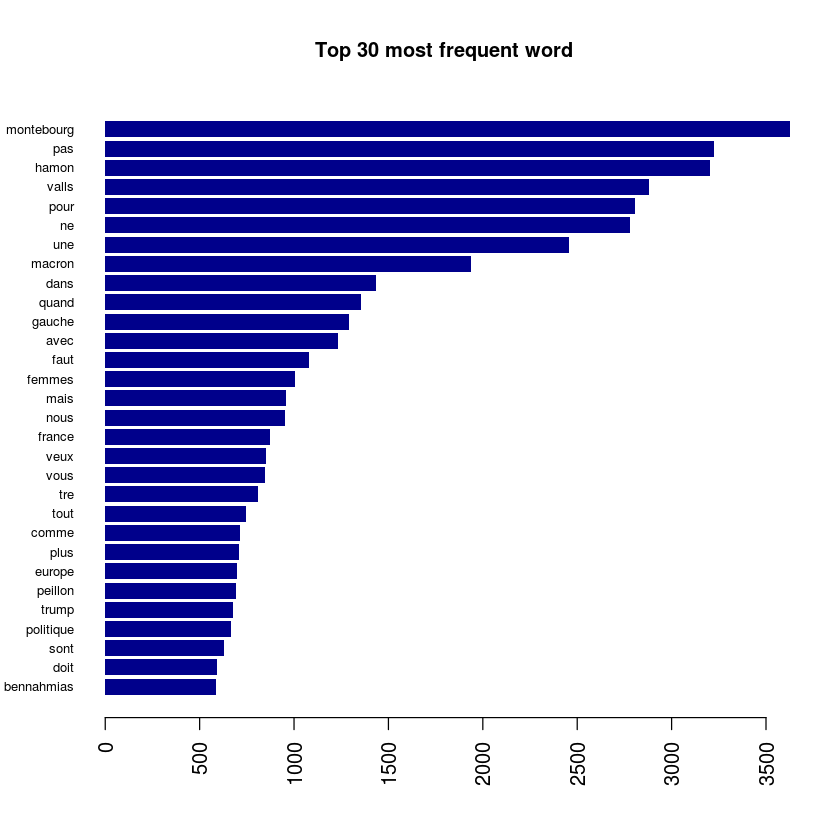

In [12]:
top30 = number_Top(tweets$text, "[a-zA-Z]\\w+ *", 30, FALSE)
barplot(top30, border=NA, las=2, main="Top 30 most frequent word", cex.main=1, horiz=TRUE, col= "darkblue", cex.names=0.65)

<font color="#2E1698" size = 3.2>We can see in the display of the 30 most frequent word that some of them are not revelant like the preposition 'dans' so we want to clean our text again.<br>
We can also do like we did in english analysis creating stopwords_regex.
</font>

In [13]:
#install.packages("tm")
library(tm)
stopwords('french')
stopwords_regex = paste(stopwords('french'), collapse = '\\b|\\b')
stopwords_regex = paste0('\\b', stopwords_regex, '\\b')

Loading required package: NLP


[1] "au"       "aux"      "avec"     "ce"       "ces"      "dans"    
  [7] "de"       "des"      "du"       "elle"     "en"       "et"      
 [13] "eux"      "il"       "je"       "la"       "le"       "leur"    
 [19] "lui"      "ma"       "mais"     "me"       "même"     "mes"     
 [25] "moi"      "mon"      "ne"       "nos"      "notre"    "nous"    
 [31] "on"       "ou"       "par"      "pas"      "pour"     "qu"      
 [37] "que"      "qui"      "sa"       "se"       "ses"      "son"     
 [43] "sur"      "ta"       "te"       "tes"      "toi"      "ton"     
 [49] "tu"       "un"       "une"      "vos"      "votre"    "vous"    
 [55] "c"        "d"        "j"        "l"        "à"        "m"       
 [61] "n"        "s"        "t"        "y"        "été"      "étée"    
 [67] "étées"    "étés"     "étant"    "suis"     "es"       "est"     
 [73] "sommes"   "êtes"     "sont"     "serai"    "seras"    "sera"    
 [79] "serons"   "serez"    "seront"   "serais"   "serait"   "serions" 
 [85] "seriez"   "seraient" "étais"    "était"    "étions"   "étiez"   
 [91] "étaient"  "fus"      "fut"      "fûmes"    "fûtes"    "furent"  
 [97] "sois"     "soit"     "soyons"   "soyez"    "soient"   "fusse"   
[103] "fusses"   "fût"      "fussions" "fussiez"  "fussent"  "ayant"   
[109] "eu"       "eue"      "eues"     "eus"      "ai"       "as"      
[115] "avons"    "avez"     "ont"      "aurai"    "auras"    "aura"    
[121] "aurons"   "aurez"    "auront"   "aurais"   "aurait"   "aurions" 
[127] "auriez"   "auraient" "avais"    "avait"    "avions"   "aviez"   
[133] "avaient"  "eut"      "eûmes"    "eûtes"    "eurent"   "aie"     
[139] "aies"     "ait"      "ayons"    "ayez"     "aient"    "eusse"   
[145] "eusses"   "eût"      "eussions" "eussiez"  "eussent"  "ceci"    
[151] "cela"     "celà"     "cet"      "cette"    "ici"      "ils"     
[157] "les"      "leurs"    "quel"     "quels"    "quelle"   "quelles" 
[163] "sans"     "soi"

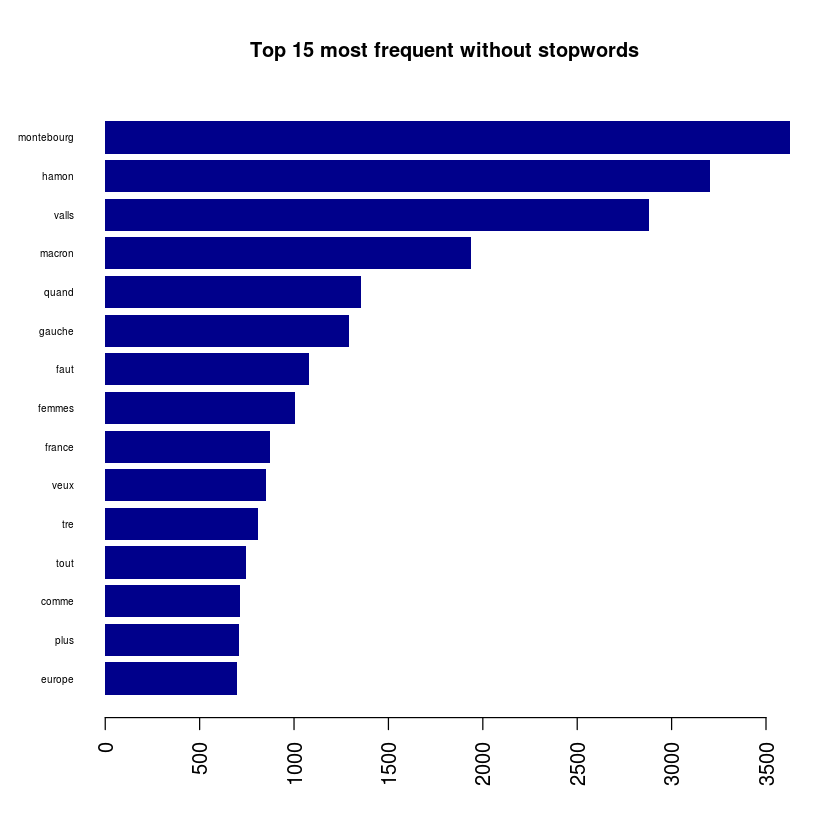

In [14]:
tweets$text_cleaned = stringr::str_replace_all(tweets$text, stopwords_regex, '')

top15 = number_Top(tweets$text_cleaned, "[a-zA-Z]\\w+ *", 15, TRUE)
barplot(sort(top15), border=NA, las=2, main="Top 15 most frequent without stopwords", cex.main=1, horiz=TRUE, col= "darkblue", cex.names=0.5)

<font color="#2E1698" size = 3.2>
As there is still not meaningful word we removed it by hand with a clean prepositions function.
</font>

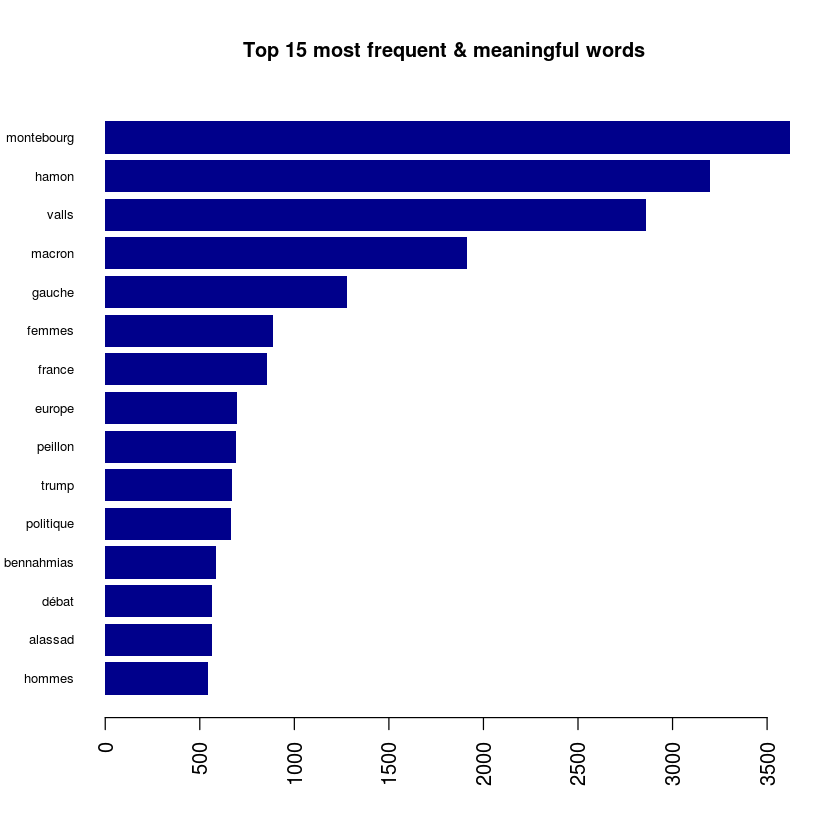

In [15]:
clean_prepo_text = function(x){
    x = gsub("quand ", "", x)
    x = gsub("faut ", "", x)
    x = gsub("veux ", "", x)
    x = gsub("tre ", "", x)
    x = gsub("tout ", "", x)
    x = gsub("plus ", "", x)
    x = gsub("doit ", "", x)
    x = gsub("fait ", "", x)
    x = gsub("faire ", "", x)
    x = gsub("comme ", "", x)
    x = gsub("tout ", "", x)
    x = gsub("quand ", "", x)
    x = gsub("suis ", "", x)
}

column_cleaned_prepo <- clean_prepo_text(tweets$text_cleaned)

top15 = number_Top(column_cleaned_prepo, "[a-zA-Z]\\w+ *", 15, FALSE)
barplot(top15, border=NA, las=2, main="Top 15 most frequent & meaningful words", cex.main=1, horiz=TRUE, col= "darkblue", cex.names=0.65)

<br>
<p><font size=4.5 color="#206B50"><center><B>PART II - 2: LIST OF THE 2 PAIRS OF WORDS HAVING THE HIGHEST CO_OCCURRENCE FREQUENCY</B></center></font></p>

<font color="#2E1698" size = 3.2>As we did before we will select, in a first time, more words than necessary in order to have a larger palette of work. <br>
So let's recover the top 20 of the most used words, and thanks to the package "tm" (need R 3.3.2) find the most correlated words to both of those top 20 having at least a cooccurrence score of 0.3. 
</font>

In [16]:
library(tm) # need R 3.3.2
docs <- Corpus(VectorSource(tweets$text))
dtm <- TermDocumentMatrix(docs)

top20 = number_Top(column_cleaned_prepo, "[a-zA-Z]\\w+ *", 20, FALSE)
associations = findAssocs(dtm, names(top20), corlimit = 0.3)
associations

$loup
    quand programme 
     0.56      0.31 

$flou
    quand programme 
     0.55      0.31 

$tous
incapacité  mobilisés  concernés     misère    partage 
      0.41       0.41       0.39       0.39       0.39 

$galité
numeric(0)

$monde
    pourris      sourde sous-titres      suivre    francetv        tout 
       0.67        0.67        0.67        0.65        0.61        0.54 
       suis        sont       comme        veux        mais 
       0.45        0.41        0.40        0.37        0.33 

$hommes
rivalisent       sept 
      0.34       0.31 

$alassad
solution   relève 
    0.36     0.31 

$débat
numeric(0)

$bennahmias
numeric(0)

$politique
étrangère 
     0.45 

$trump
 donald sérieux 
   0.34    0.34 

$peillon
vincent 
   0.46 

$europe
disloquer      unie     forte   réponse 
     0.48      0.48      0.42      0.33 

$france
numeric(0)

$femmes
    droits  ministère  violences     budget doublement     harcèl  notamment 
      0.48       0.47       0.44       0.41       0.38       0.38       0.36 
    lutter 
      0.34 

$gauche
numeric(0)

$macron
numeric(0)

$valls
numeric(0)

$hamon
numeric(0)

$montebourg
numeric(0)

<font color="#2E1698" size = 3.2>Now that we have discover all the associations, we want to generate an algorithm able to organize intelligently those data as a dataframe no matter how is the input / text / subject / ... <br>
Once the dataframe is created using '|' as separator we can create easily several columns.
</font>

In [17]:
vect = c()

for(i in 1:15){
    size1 = length(associations[i][[1]])
    if(size1 > 0){
        size2 = length(associations[i][[1]])
        for(j in 1:size2){
            vect = c(vect, paste0(names(top20)[i],"|" , names(associations[i][[1]][j]), "|",associations[i][[1]][[j]][1]))
        }  
    }
}

cooccurrence_df = data.frame(vect)
head(cooccurrence_df)

cooccurrence_df <- data.frame(do.call('rbind', strsplit(as.character(cooccurrence_df$vect),'|',fixed=TRUE)))
colnames(cooccurrence_df) <- c("word_1", "word_2", "score")
head(cooccurrence_df)

vect
loup|quand|0.56
loup|programme|0.31
flou|quand|0.55
flou|programme|0.31
tous|incapacité|0.41
tous|mobilisés|0.41


word_1,word_2,score
loup,quand,0.56
loup,programme,0.31
flou,quand,0.55
flou,programme,0.31
tous,incapacité,0.41
tous,mobilisés,0.41


<font color="#2E1698" size = 3.2>Now that we have a proper dataframe, we can sort it by score and recover the best cooccurrence.</font>

In [18]:
cooccurrence_df = cooccurrence_df[with(cooccurrence_df, order(-as.numeric(score), word_1)), ]
head(cooccurrence_df, n=15)

,word_1,word_2,score
10,monde,pourris,0.67
11,monde,sourde,0.67
12,monde,sous-titres,0.67
13,monde,suivre,0.65
14,monde,francetv,0.61
1,loup,quand,0.56
3,flou,quand,0.55
15,monde,tout,0.54
29,europe,disloquer,0.48
30,europe,unie,0.48


<p><font size=4.5 color="#206B50"><center><B>PART III - 1: GRAPHICAL REPRESENTATION</B></center></font></p>
<font color="#2E1698" size = 3.2>The first graphical representation we'll do is a wordcloud representing what we found in the part above (most used words). To do that we will use wordcloud library which is really representative for our work. Let's see what does it look like in our case.</font>

Loading required package: RColorBrewer


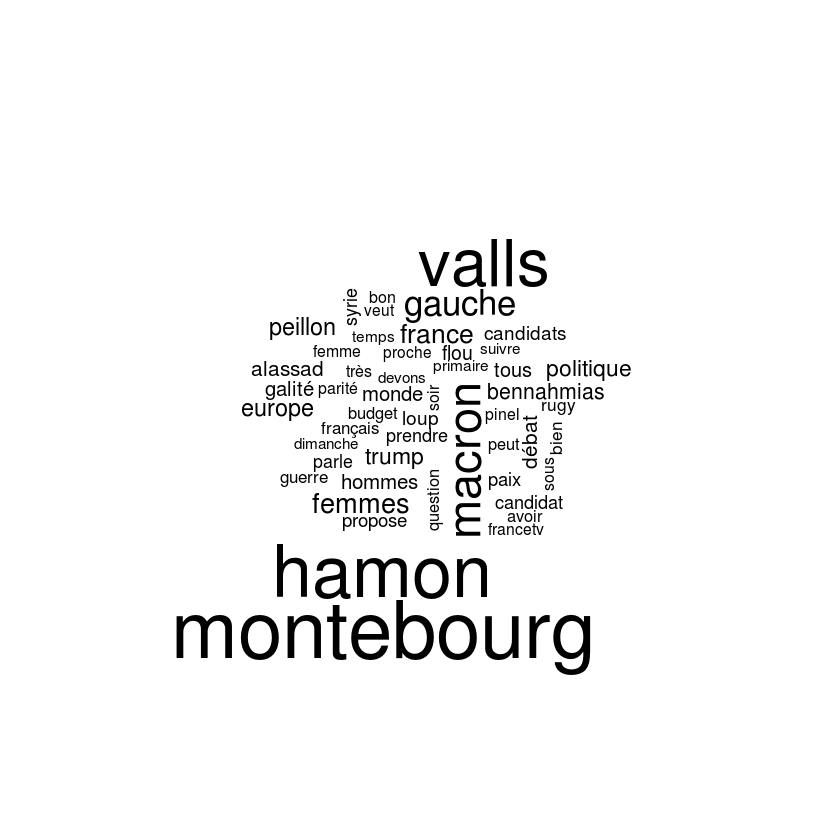

In [19]:
library(SnowballC)
library(wordcloud)

top50 = number_Top(column_cleaned_prepo, "[a-zA-Z]\\w+ *", 50, FALSE)
wordcloud(names(top50), top50, min.freq=2)

In [20]:
library(wordcloud2)

top100 = number_Top(column_cleaned_prepo, "[a-zA-Z]\\w+ *", 100, FALSE)
cat("The letterCloud function does not work on Jupyter notebook, if you are using markdown, you can uncomment this line.")
#letterCloud(top100, word = "PS", wordSize = 1)

ERROR: Error in library(wordcloud2): there is no package called ‘wordcloud2’


<font color="#2E1698" size = 3.2>The first step is to categorize each tweet then we will see the most common word in each category (positive, neutral, negative). So far we have found and traduce a list of positive and negative words, stored into a .txt file.</font>

In [49]:
#evaluation tweets function
sentence <- tweets$text

score.sentiment <- function(sentences, pos.words, neg.words, .progress='none')
{
  require(plyr)
  require(stringr)
  scores <- laply(sentences, function(sentence, pos.words, neg.words){
    word.list <- str_split(sentence, ' ')
    words <- unlist(word.list)
    pos.matches <- match(words, pos.words)
    neg.matches <- match(words, neg.words)
    pos.matches <- !is.na(pos.matches)
    neg.matches <- !is.na(neg.matches)
    score <- sum(pos.matches) - sum(neg.matches)
    return(score)
  }, pos.words, neg.words, .progress=.progress)
 scores.df <- data.frame(score=scores, text=sentences)
 return(scores.df)
}

yourPath = paste0(getwd(),"/data/NegPos/Positive.txt")
pos <- scan(yourPath, what='character', comment.char=';') #folder with positive dictionary
yourPath = paste0(getwd(),"/data/NegPos/Negative.txt")
neg <- scan(yourPath, what='character', comment.char=';') #folder with negative dictionary
scores <- score.sentiment(sentence, pos, neg, .progress='text')

  |======================================================================| 100%


In [50]:
#total evaluation: positive / negative / neutral
stat <- scores
stat$created <- tweets$created
stat$created <- as.Date(stat$created)
stat <- mutate(stat, tweet=ifelse(stat$score > 0, 'positive', ifelse(stat$score < 0, 'negative', 'neutral')))
head(stat)

score,text,created,tweet
-1,débat intéressnt encore espoir ne oublions pas bon président président engagé,2017-01-19,negative
-1,bon avez vous bien collectés données bonne nuit,2017-01-19,negative
0,valls veux incarner espérance venez voter dimanche valls,2017-01-19,neutral
1,valls nous avons besoin une europe forte unie valls valls,2017-01-19,positive
-1,donc valls coup nous sauver,2017-01-19,negative
3,progrès précis crédible gauche dans conclusion,2017-01-19,positive


<font color="#2E1698" size = 3.2>As you can see here there is a problem, some tweets are not scored as they should be. For example the word "incarner" could be in the 'Positive' dictionary but written as "incarne" or "incarné". We should use stemming both on our tweets and on our positive/negative dictionaries.</font>
<br/>
<font color="#2E1698" size = 3.2>Let's see what we get using stemming this time!</font>

In [51]:
# This function will use stemming on a list
stemming = function(unstem_list){
  # To use stemming we have to convert our list of words into a corpus.
  list_corpus <- VCorpus(VectorSource(unstem_list))
  list_stem <- tm_map(list_corpus, PlainTextDocument)  # needs to come before stemming
  list_stem <- tm_map(list_stem, stemDocument, "french")
  #Converting the corpus into a dataframe
  dataframe_stemmed<-data.frame(text=unlist(sapply(list_stem, `[`, "content")), stringsAsFactors=F)
  return(dataframe_stemmed)
}

# This function will use stemming on a dictionary
stemming_dictionary = function(path){
  yourPath = paste0(getwd(),path)
  # First we read the dictionary and store it into a variable
  dictionary = read.table(yourPath, sep='\n')
  # There might be some values present more than once, so let's make it unique
  dictionary = unique(dictionary)
  dictionary = dictionary$V1
  dataframe_stemmed = stemming(dictionary)
  dataframe_stemmed<-unique(dataframe_stemmed)
  return(dataframe_stemmed)
}
neg_stem = stemming_dictionary("/data/NegPos/Negative.txt")$text                                 
head(neg_stem)
pos_stem = stemming_dictionary("/data/NegPos/Positive.txt")$text                                 
head(pos_stem)
                                                                
# And now we create 2 txt files containing the words negative and positive after stemming
# 

#write.table(z_neg, file = "NegPos/NegativeStem.txt", append = FALSE, quote = FALSE, sep = "\n",
#            na = "NA", dec = ".", row.names = FALSE,
#            col.names = FALSE)
#write.table(z_pos, file = "NegPos/PositiveStem.txt", append = FALSE, quote = FALSE, sep = "\n",
#            na = "NA", dec = ".", row.names = FALSE,
#            col.names = FALSE)

[1] "vol"      "abandon"  "abasourd" "abattag"  "abatt"    "abattu"

[1] "gagn"      "abond"     "abord"     "accessibl" "acclam"    "accolad"

In [52]:
# Stemming of the tweets
dataframe_stem <- stemming(tweets$text)

#evaluation tweets after stemming function
yourPath = paste0(getwd(),"/data/NegPos/PositiveStem.txt")
pos <- scan(yourPath, what='character', comment.char=';') #folder with positive dictionary
yourPath = paste0(getwd(),"/data/NegPos/NegativeStem.txt")
neg <- scan(yourPath, what='character', comment.char=';') #folder with negative dictionary

#scores <- score.sentiment(dataframe_stem$text, z_pos, z_neg, .progress='text')
scores <- score.sentiment(dataframe_stem$text, pos_stem, neg_stem, .progress='text')

  |======================================================================| 100%


In [53]:
#total evaluation: positive / negative / neutral
 stat <- scores
 stat$originalTweet <- tweets$originalTweet
 stat$cleanTweet <- tweets$text
 stat <- mutate(stat, tweet=ifelse(stat$score > 0, 'positive', ifelse(stat$score < 0, 'negative', 'neutral')))

head(stat)

score,text,originalTweet,cleanTweet,tweet
1,débat intéressnt encor espoir ne oublion pas bon président président engag,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,débat intéressnt encore espoir ne oublions pas bon président président engagé,positive
0,bon avez vous bien collect don bon nuit,C'est bon @GoogleFR @TwitterFrance avez vous bien collectés mes données ? Bonne nuit #numerique #bigdata #PrimaireLeDébat,bon avez vous bien collectés données bonne nuit,neutral
0,vall veux incarn esper ven vot dimanch vall,"RT @DeLuca_Patrice: .@manuelvalls ""Je veux incarner l'espérance, venez voter dimanche!"" #AvecValls #PrimaireLeDebat",valls veux incarner espérance venez voter dimanche valls,neutral
0,vall nous avon besoin une europ fort uni vall vall,"RT @DeLuca_Patrice: .@manuelvalls ""Nous avons besoin d'une Europe forte et unie"" #AvecValls #PrimaireLeDebat #Valls2017",valls nous avons besoin une europe forte unie valls valls,neutral
-1,donc vall coup nous sauv,RT @LPF_Paris18: #PrimaireLeDebat Dis donc @manuelvalls c'est à coup de #decheancedenationalite et de #49Al3 que tu penses nous sauver? #Mo…,donc valls coup nous sauver,negative
3,progres prec crédibl gauch dan conclus,"""J'ai un progrès précis, crédible, de gauche"", a dit @Vincent_Peillon dans sa conclusion https://t.co/Zs9UHNLcNb… https://t.co/mBtiNvJIAb",progrès précis crédible gauche dans conclusion,positive


<font color="#2E1698" size = 3.2>Now that we have a score on each tweet, let's study the words' occurence.</font><br>
<font color="#2E1698" size = 3.2>We are going to simply see, like we did before, which word is appearing the most in our positive/negative only dataframe taht we are going to create.</font>

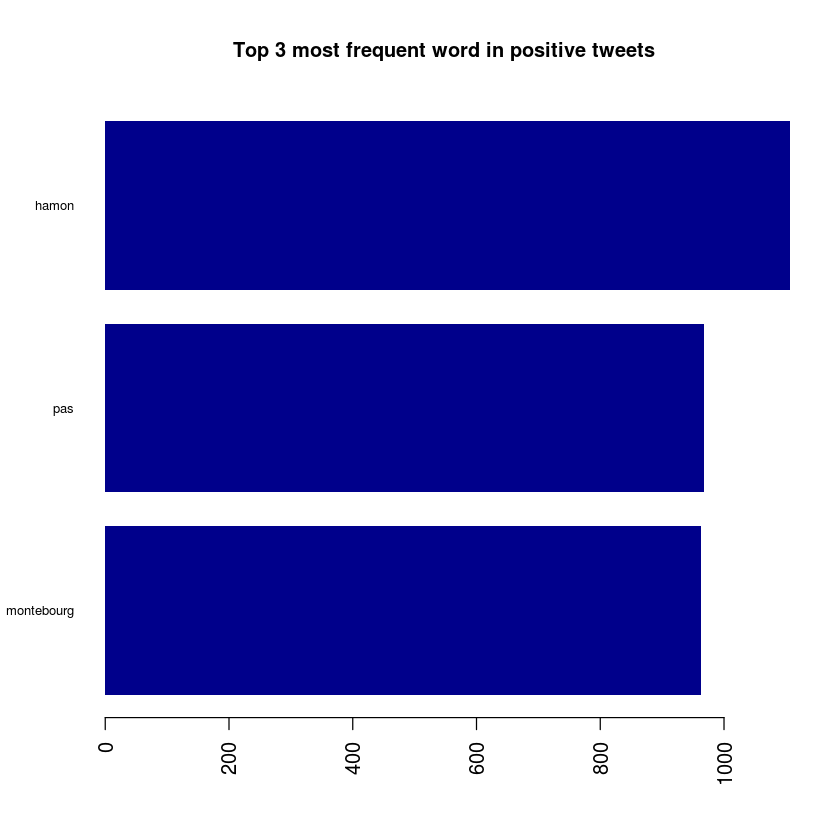

In [65]:
# Building a dataframe with only positive tweets.
positive_tweets = subset(stat, tweet == 'positive')

# Let's see which are the word that appear the most:
tweet = positive_tweets$cleanTweet
tweet = gsub("une", "", tweet)
#Using the function number_top already defined before:
top3pos = number_Top(tweet, "[a-zA-Z]\\w+ *", 3, FALSE)
barplot(top3pos, border=NA, las=2, main="Top 3 most frequent word in positive tweets", 
        cex.main=1, horiz=TRUE, col= "darkblue", cex.names=0.65)

Var1,Freq
ne,982
montebourg,1080
pas,1192


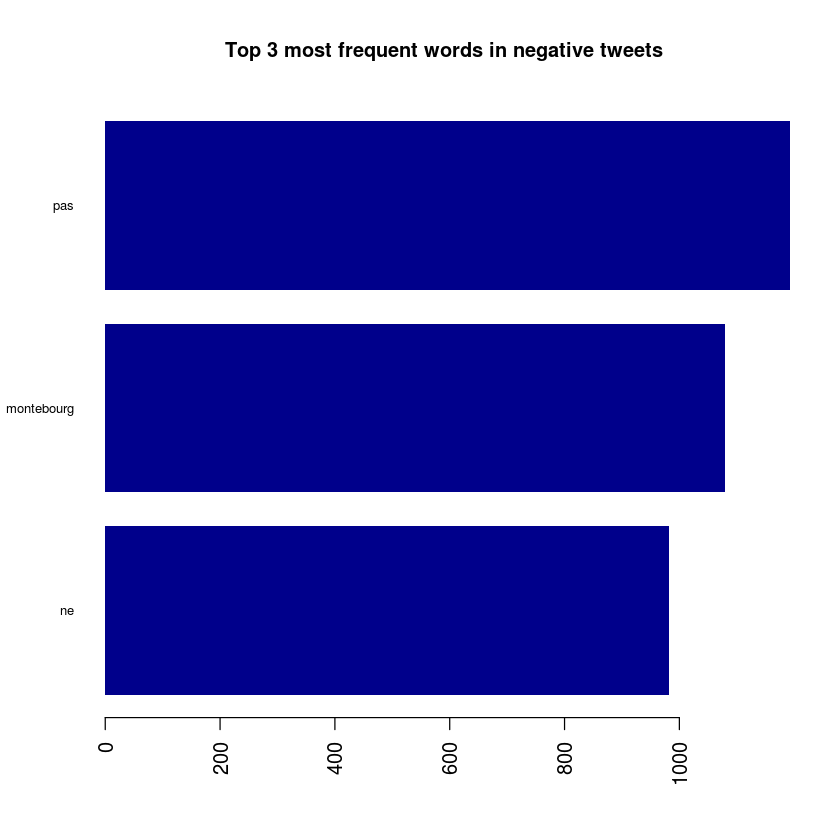

In [66]:
# Building a dataframe with only negative tweets.
negative_tweets = subset(stat, tweet == 'negative')

# Let's see which are the word that appear the most (again):
tweet = negative_tweets$cleanTweet

#Using the function number_top already defined before:
top3neg = number_Top(tweet, "[a-zA-Z]\\w+ *", 3, FALSE)
head(data.frame(top3))
barplot(top3neg, border=NA, las=2, main="Top 3 most frequent words in negative tweets", 
        cex.main=1, horiz=TRUE, col= "darkblue", cex.names=0.65)

Var1,Freq,polarity
ne,982,neg
montebourg,1080,neg
pas,1192,neg
montebourg,963,pos
pas,968,pos
hamon,1106,pos


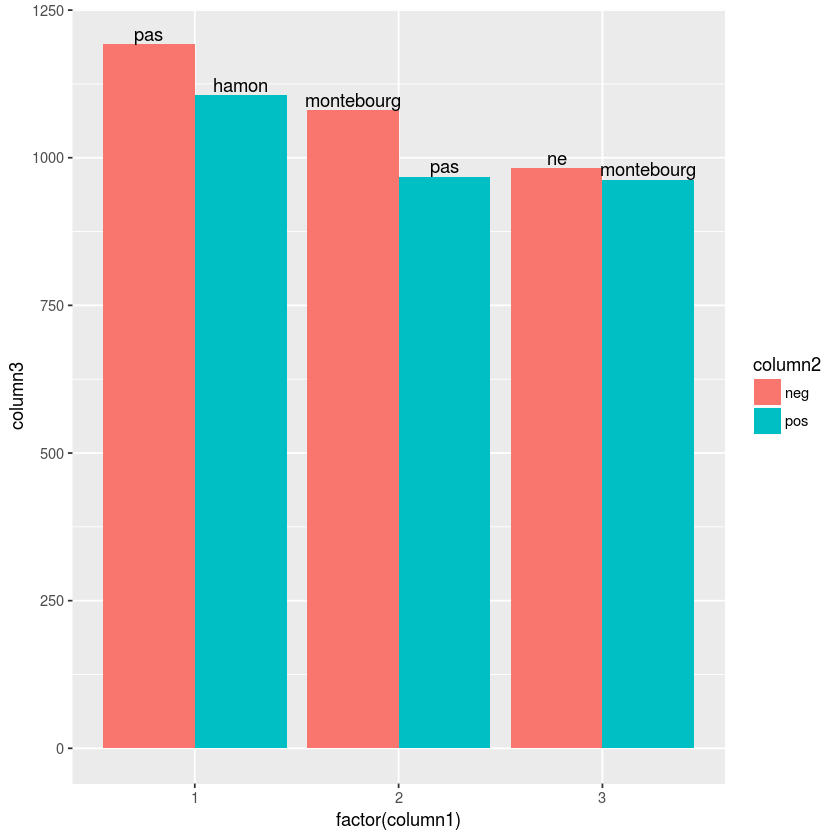

In [92]:
#install.packages('ggplot2', dependencies = TRUE)
library(ggplot2)
dfpos = data.frame(top3pos)
dfneg = data.frame(top3neg)
dfpos$polarity = "pos"
dfneg$polarity = 'neg'
df = rbind(dfneg, dfpos)
head(df)

d <- data.frame(column1=rep(c("1","2","3"), each=2), 
                column2=rep(c("neg", "pos"), 3), 
                column3=c(1192, 1106, 1080, 968, 982, 963),
                column4 = c('pas', 'hamon', 'montebourg', 'pas', 'ne', 'montebourg')
               )

ggplot(d, aes(factor(column1), column3, fill = column2)) + geom_bar(stat="identity", position = "dodge") + 
  geom_text(aes(label=column4), vjust=-0.250, position=position_dodge(width=0.9))


<font color="#2E1698" size = 3.2>Well, we can see after this little study that there is not much differences between 'positive' and 'negative' tweets. The most occuring words are neither positive or negative and are the same as in the top 15 we did before.</font>
<br/><br/>
<font color="#2E1698" size = 3.2>Now let's see what we get using another strategy:
    <ol>
      <li>Building a column containing only positive/negative words of a tweet</li>
      <li>Analyse this column only and see which words are appearing the most</li>
    </ol>
</font>

In [56]:
extract_words = function(path, df_tweets){
  #Building positive.words column:
  yourPath = paste0(getwd(),path)
  dictionary <- scan(yourPath, what='character', comment.char=';')
  word.list <- str_split(df_tweets$text, " ")
  df_tweets$dictionary.words <- word.list

  # this function will create a list of words by comparing if the words in tweet are in the dictionary
  dictionary_words = function(sentence){
    b = c()
    i = 0
    for(w in sentence){
      if(w %in% dictionary){
        i = i + 1
        b[i] <- w
      }
    }
    return(b)
  }
  df_tweets$dictionary.words <- lapply(df_tweets$dictionary.words, dictionary_words)
  return(df_tweets)
}
positive_tweets = extract_words("/data/NegPos/PositiveStem.txt", positive_tweets)
negative_tweets = extract_words("/data/NegPos/NegativeStem.txt", negative_tweets)
head(positive_tweets)

,score,text,originalTweet,cleanTweet,tweet,dictionary.words
1,1,débat intéressnt encor espoir ne oublion pas bon président président engag,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,débat intéressnt encore espoir ne oublions pas bon président président engagé,positive,engag
6,3,progres prec crédibl gauch dan conclus,"""J'ai un progrès précis, crédible, de gauche"", a dit @Vincent_Peillon dans sa conclusion https://t.co/Zs9UHNLcNb… https://t.co/mBtiNvJIAb",progrès précis crédible gauche dans conclusion,positive,"progres, prec , crédibl"
9,1,apres plai egypt franc droit soir plai franc,"RT @AnneYunie59000: #PrimaireLeDebat Après les 7 plaies d'Egypte ,les Français ont le droit ce soir aux 7 plaies de la France .",après plaies egypte français droit soir plaies france,positive,droit
11,1,comm hamon compt vous,Comme @benoithamon je compte sur vous ! #PrimaireLeDebat https://t.co/FZOnuGnn1K,comme hamon compte vous,positive,NULL
13,2,veux comm une major franc droit mour dan dignit une loi permet euthan,"RT @benoithamon: #PrimaireLeDebat Je veux, comme une majorité de Français, un droit à mourir dans la dignité, une loi permettant l'euthanas…",veux comme une majorité français droit mourir dans dignité une loi permettant euthanas,positive,"droit , dignit"
14,3,beaucoup moin attrai primair droit comm une affich équip milieu tableau,#PrimaireLeDebat Beaucoup moins attrayant que la Primaire de droite. Comme une affiche d'équipes de milieu de tableau ...,beaucoup moins attrayant primaire droite comme une affiche équipes milieu tableau,positive,"moin , attrai, droit"


In [57]:
# New cell
extract_words = function(path1, path2, df_tweets){
  #Building positive.words column:
  yourPath = paste0(getwd(),path1)
  dictionary1 <- scan(yourPath, what='character', comment.char=';')
  yourPath = paste0(getwd(),path2)
  dictionary2 <- scan(yourPath, what='character', comment.char=';')
  word.list <- str_split(df_tweets$text, " ")
  df_tweets$dictionary.words <- word.list

  # this function will create a list of words by comparing if the words in tweet are in the dictionary
  dictionary_words = function(sentence){
    b = c()
    i = 0
    for(w in sentence){
      if(w %in% dictionary1 || w %in% dictionary2){
        i = i + 1
        b[i] <- w
      }
    }
    return(b)
  }
  df_tweets$dictionary.words <- lapply(df_tweets$dictionary.words, dictionary_words)
  return(df_tweets)
}
stat = extract_words("/data/NegPos/PositiveStem.txt","/data/NegPos/NegativeStem.txt", stat)
head(stat)

score,text,originalTweet,cleanTweet,tweet,dictionary.words
1,débat intéressnt encor espoir ne oublion pas bon président président engag,Ce fut un débat intéressnt ! Ccl :Il y'a encore de l'espoir!N'oublions pas qu'un bon président est un président engagé ! #PrimaireLeDebat,débat intéressnt encore espoir ne oublions pas bon président président engagé,positive,engag
0,bon avez vous bien collect don bon nuit,C'est bon @GoogleFR @TwitterFrance avez vous bien collectés mes données ? Bonne nuit #numerique #bigdata #PrimaireLeDébat,bon avez vous bien collectés données bonne nuit,neutral,"bien, don , nuit"
0,vall veux incarn esper ven vot dimanch vall,"RT @DeLuca_Patrice: .@manuelvalls ""Je veux incarner l'espérance, venez voter dimanche!"" #AvecValls #PrimaireLeDebat",valls veux incarner espérance venez voter dimanche valls,neutral,NULL
0,vall nous avon besoin une europ fort uni vall vall,"RT @DeLuca_Patrice: .@manuelvalls ""Nous avons besoin d'une Europe forte et unie"" #AvecValls #PrimaireLeDebat #Valls2017",valls nous avons besoin une europe forte unie valls valls,neutral,"fort, uni"
-1,donc vall coup nous sauv,RT @LPF_Paris18: #PrimaireLeDebat Dis donc @manuelvalls c'est à coup de #decheancedenationalite et de #49Al3 que tu penses nous sauver? #Mo…,donc valls coup nous sauver,negative,coup
3,progres prec crédibl gauch dan conclus,"""J'ai un progrès précis, crédible, de gauche"", a dit @Vincent_Peillon dans sa conclusion https://t.co/Zs9UHNLcNb… https://t.co/mBtiNvJIAb",progrès précis crédible gauche dans conclusion,positive,"progres, prec , crédibl"


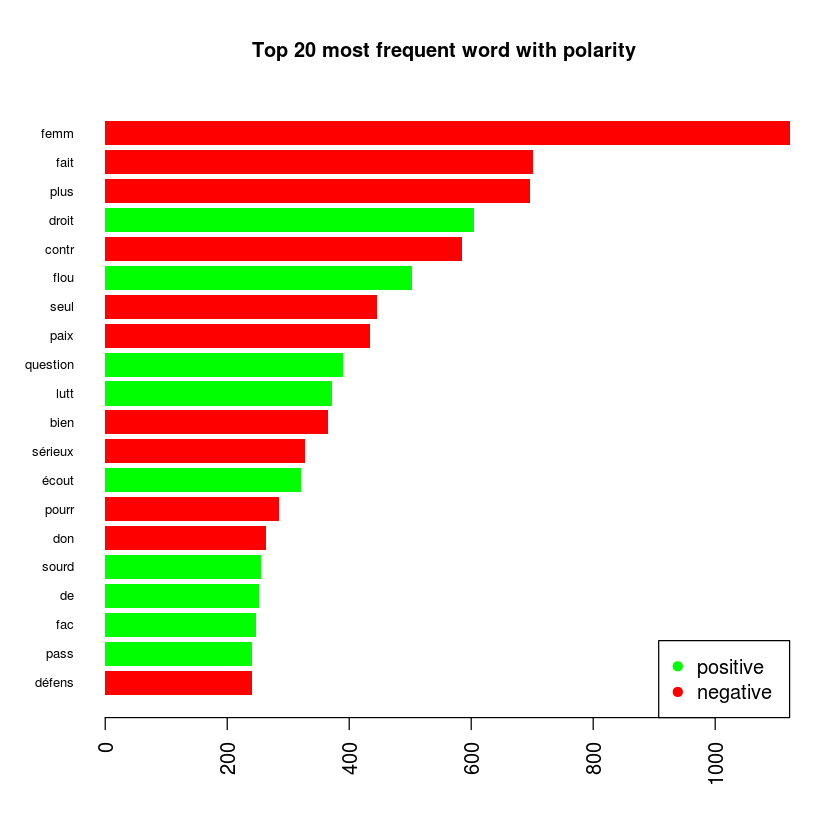

In [58]:
# New cell
words.vector<-unlist(stat$dictionary.words)
freq.list<-table(words.vector)
sorted.freq.list<-sort(freq.list, decreasing=TRUE)
mfw = head(sorted.freq.list, n = 100, decreasing = FALSE)
df_words_freq = data.frame(mfw)
a = 0
path_pos = "/data/NegPos/PositiveStem.txt"
path_neg = "/data/NegPos/NegativeStem.txt"
yourPath = paste0(getwd(), path_pos)
pos_dictionary <- scan(yourPath, what='character', comment.char=';')
yourPath = paste0(getwd(), path_neg)
neg_dictionary <- scan(yourPath, what='character', comment.char=';')
for(i in df_words_freq$words.vector){
    a = a + 1
    if(i %in% pos_dictionary){
        df_words_freq$polarity[a] = "pos"
    }
    else if(i %in% neg_dictionary){
        df_words_freq$polarity[a] = "neg"
    }
    
}

    # Liste à inverser...:    
barplot(sort(head(mfw, 20)), border=NA, las=2, main="Top 20 most frequent word with polarity", 
        cex.main=1, horiz=TRUE, col= ifelse(df_words_freq$polarity == "pos", 'green', 'red'), cex.names=0.65)
legend("bottomright", c("positive","negative"), pch=c(19,19), col=c("green","red"))

In [59]:
df_pos_words = df_words_freq[which(df_words_freq$polarity == "pos"),]
df_neg_words = df_words_freq[which(df_words_freq$polarity == "neg"),]
df_pos_words = head(df_pos_words, 20)
df_neg_words = head(df_neg_words, 20)
df_pos_words$Freq <- NULL
df_pos_words$polarity <- NULL
df_neg_words$Freq <- NULL
df_neg_words$polarity <- NULL

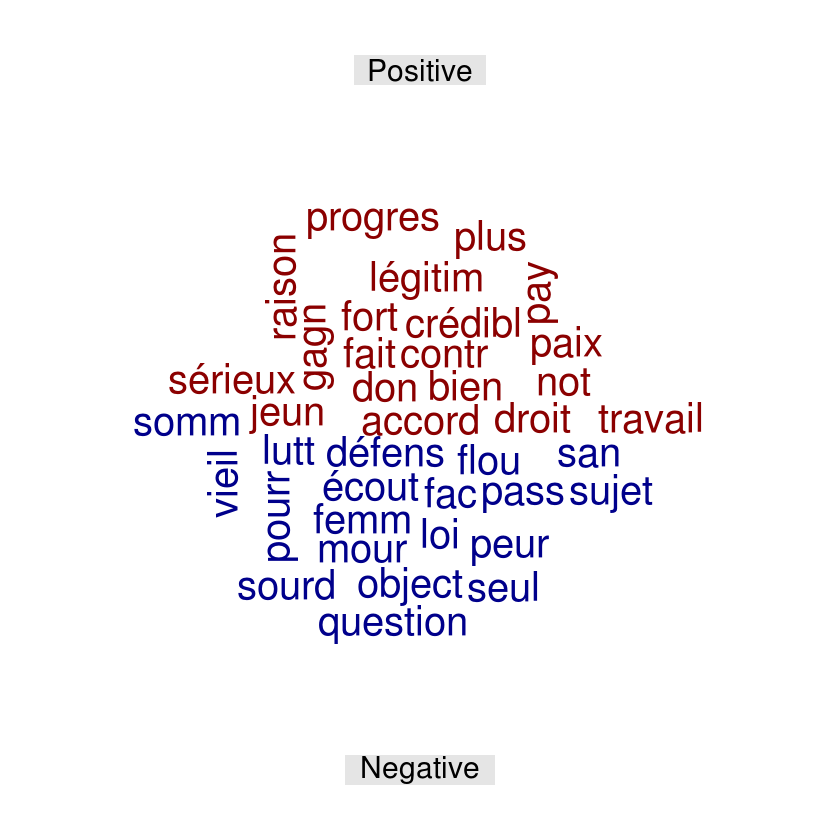

In [60]:
all = c(df_pos_words, df_neg_words)

# create corpus
corpus = Corpus(VectorSource(all))

# create term-document matrix
tdm = TermDocumentMatrix(corpus)

# convert as matrix
tdm = as.matrix(tdm)

# add column names
colnames(tdm) = c("Positive", "Negative")

comparison.cloud(tdm, random.order=FALSE, colors = c("darkred", "darkblue", "blue", "darkblue"), 
                 title.size=1.5, max.words=500, scale=c(2,.5))

<p><font size=4.5 color="#206B50"><center><B>PART III - 2: Indicate 3 most frequent words in each category</B></center></font></p>

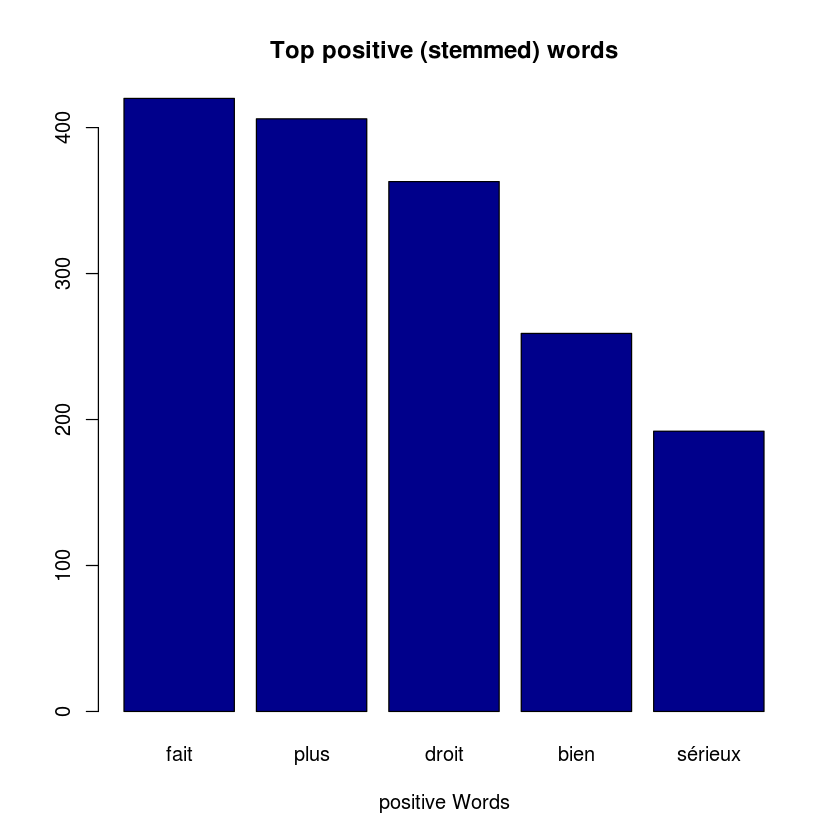

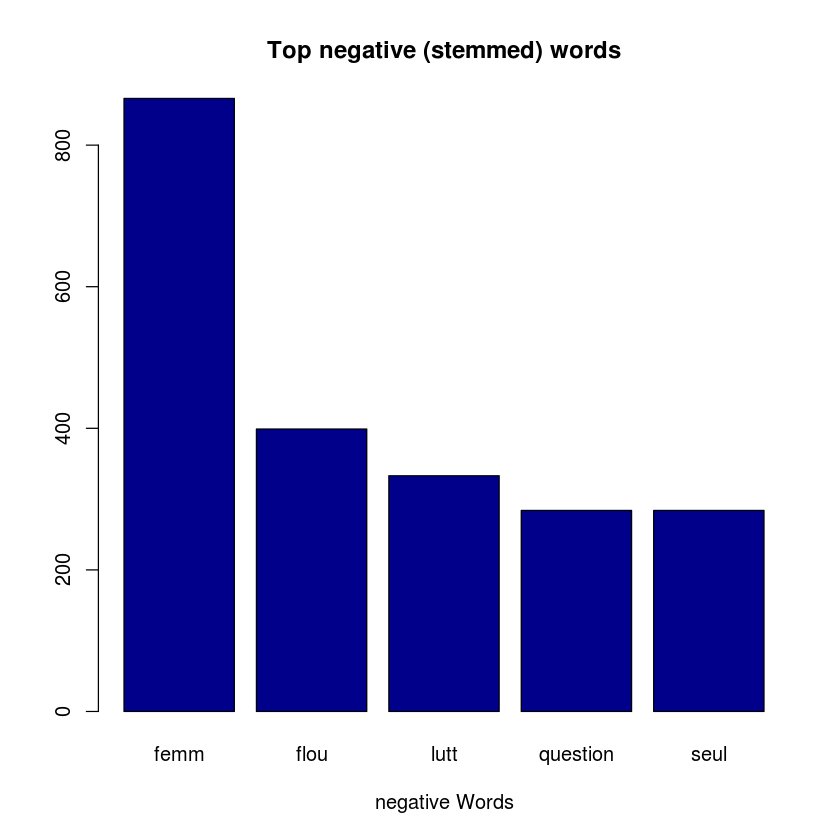

In [61]:
#Plotting our result
plot_words = function(df_tweets){
  words.vector<-unlist(df_tweets$dictionary.words)
  freq.list<-table(words.vector)
  sorted.freq.list<-sort(freq.list, decreasing=TRUE)
  mfw = head(sorted.freq.list, n = 5)
  return(mfw)
}
mfw_pos = plot_words(positive_tweets)
mfw_neg = plot_words(negative_tweets)
# Simple Bar Plot 
barplot(mfw_pos, main="Top positive (stemmed) words", xlab="positive Words", col = "darkblue")
barplot(mfw_neg, main="Top negative (stemmed) words", xlab="negative Words", col = "darkblue")

<font color="#2E1698" size = 3.2>So, we can see here for the positive stemmed words with the highest appearence frequency in positive tweets. We have:
    <ol>
      <li>'fait', the word with the highest frequency.</li>
      <li>'plus'</li>
      <li>'droit', with stemming it regroups also words of the same root, like: 
        <ol>
          <li>droits</li>
          <li>droite</li>
          <li>droites</li>
        </ol>
      </li>
      <li>'bien'</li>
      <li>'sérieux'</li>
    </ol>
</font>
<br/>
<font color="#2E1698" size = 3.2>Same thing for negative stemmed words with the highest appearence frequency in negative tweets. We have:
    <ol>
      <li>'femm', the word with the highest frequency which is not even a real word but regroup words with roots like:
        <ol>
          <li>femmes</li>
          <li>femme</li>
        </ol></li>
      <li>'flou', that can regroup:
        <ol>
          <li>flou</li>
          <li>flous</li>
          <li>And maybe mispelled words like 'floux'</li>
        </ol>
      </li>
      <li>'lutt' that may regroup:
        <ol>
            <li>lutte</li>
            <li>luttes</li>
            <li>lutter, etc.</li>
        </ol>
      </li>
      <li>'question'</li>
      <li>'seul'</li>
    </ol>
</font>

<p><font size=4.5 color="#206B50"><center><B>PART III - 3: Compare the results of the two approaches</B></center></font></p>